# Setup File Structure and the Dataframes

This project was completed on Kaggle. The ROOT directory can be changed here to allow the project to be run elsewere.

In [1]:
import pandas as pd
import numpy as np


ROOT = "/kaggle/input/multichannel-glaucoma-benchmark-dataset"

data = pd.read_csv(ROOT + '/metadata - standardized.csv', index_col=None)
print(len(data))
data.head()

12449


,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For this project we are only interested in the records that include patient demographics data. We filter out only the records that contain the RFIs, the ages, and sex of individuals. We also remove all cases where the diagnosis is '-1' which corresponds to 'suspect' to allow this to be a binary classification tasks: healthy or glaucomatous.

In [2]:
fundus_subset = data[(data['fundus'].notnull()) & (data['types'] != -1) & (data['age'].notnull() & (data['sex'].notnull()))]
fundus_subset = fundus_subset[['types', 'fundus', 'names', 'age', 'sex']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset['sex'] = fundus_subset['sex'].map({'M': 0, 'F': 1})

In [3]:
fundus_subset

,types,fundus,names,age,sex,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,58.0,1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,60.0,0,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,66.0,1,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,70.0,0,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,45.0,0,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...,...,...
4541,0,/full-fundus/LES-AV-18.png,LES-AV-18,53.0,1,LES-AV-18.png
4542,1,/full-fundus/LES-AV-19.png,LES-AV-19,61.0,1,LES-AV-19.png
4543,0,/full-fundus/LES-AV-20.png,LES-AV-20,71.0,0,LES-AV-20.png
4544,1,/full-fundus/LES-AV-21.png,LES-AV-21,58.0,1,LES-AV-21.png


In [4]:
# glaucoma fundus images
glaucomaCount = len(fundus_subset[(fundus_subset['types'] == '1')])
print("Glaucoma instances:", glaucomaCount)

# healthy fundus images
healthyCount = len(fundus_subset[(fundus_subset['types'] == '0')])
print("Healthy instances:", healthyCount)

# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']


# Undersample the majority class (healthy). Note that this makes us lose a lot of training instances for training.
healthy_subset = healthy_subset.sample(n=len(glaucoma_subset), random_state=1)
healthyCount = len(healthy_subset)

Glaucoma instances: 302
Healthy instances: 4162


# Train, Validation and Test Sets

We use a split of around 10% validation, and 10% test. Classes are balanced in this split. 30 healthy instances and 30 glaucomatous instances make up 60 out of the 602 total images. 30 are assigned to the validation set, and 30 to the test set.

In [5]:
testSize = 30

# get train items
healthy_train = healthy_subset.head(healthyCount - testSize)
glaucoma_train = glaucoma_subset.head(glaucomaCount - testSize)
train = healthy_train.append(glaucoma_train)

# Split the train dataset into train and validation datasets
valSize = 30
healthy_val = healthy_train.tail(valSize)
glaucoma_val = glaucoma_train.tail(valSize)
val = healthy_val.append(glaucoma_val)

# Update train dataset by removing validation samples
healthy_train = healthy_train.head(healthyCount - testSize - valSize)
glaucoma_train = glaucoma_train.head(glaucomaCount - testSize - valSize)
train = healthy_train.append(glaucoma_train)

# get test items
healthy_test = healthy_subset.tail(testSize)
glaucoma_test = glaucoma_subset.tail(testSize)
test = healthy_test.append(glaucoma_test)

print("Train Size: ", len(train))
print("Validation Size: ", len(val))
print("Test Size: ", len(test))

Train Size:  484
Validation Size:  60
Test Size:  60


# Create Baseline Model using Chosen Pretrained Model

Follow instructions in readme to use different pretrained model architectures.

In [22]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, Input, Concatenate
from keras.models import Model
from tensorflow.keras.activations import relu, softmax


from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def create_multi_input_model(image_size, extra_input_count):
    
    # Picture CNN
    model_input = Input(shape=(image_size, image_size, 3))
    transfer = InceptionV3(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    
    x = transfer.output
    x = Dropout(0.5)(x)
    x = Conv2D(filters=256, kernel_size=1)(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.5)(x)
    
    
    # Patient Data CNN
    input_2  = Input(shape=(input_count,))
    # Add more dense layers with dropout
    y = Dense(64, activation=relu)(input_2)
    y = Dropout(0.5)(y)
    y = Dense(32, activation=relu)(y)
    y = Dropout(0.5)(y)
    y = Dense(16, activation=relu)(y)
    y = Dropout(0.5)(y)
    y = Dense(8, activation=relu)(y)
    y = Dropout(0.5)(y)
    # Add the final dense layer for patient data
    y = Dense(5, activation=relu)(y)

    # Concatenate the two models together
    concat = Concatenate()([x, y])
    
    # output layer with 2 output classes and a softmax activation function
    output = Dense(units = 2, activation=softmax)(concat)
    
    return Model(inputs=[model_input, input_2], outputs=[output])

# Create Custom Data Generator Class

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence, to_categorical


class CustomImageDataGenerator(Sequence):
    def __init__(self, dataframe, x_col, y_col, extra_col, batch_size, target_size, directory, preprocessing_function=None, shuffle=True):
        self.dataframe = dataframe
        self.x_col = x_col
        self.y_col = y_col
        self.extra_col = extra_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.directory = directory
        self.preprocessing_function = preprocessing_function
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.classes = np.array(dataframe[y_col].astype(int).values)  # Cast labels to int
        self.class_indices = {label: idx for idx, label in enumerate(np.unique(self.classes))}
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch = self.dataframe.iloc[batch_indices]
        X = [self._load_image_and_preprocess(row[self.x_col]) for _, row in batch.iterrows()]
        X_extra = batch[self.extra_col].values
        X = [np.array(X), np.array(X_extra)]
        y = np.array(batch[self.y_col].astype(int).values)  # Cast labels to int
        y = to_categorical(y, num_classes=2)  # One-hot encode labels

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_image_and_preprocess(self, filename):
        img = load_img(self.directory + '/' + filename, target_size=self.target_size)
        img = img_to_array(img)
        if self.preprocessing_function:
            img = self.preprocessing_function(img)
        return img

# Create Data Generators to Read From Dataframes

In [24]:
target = 224
batchSize = 8

trainGen = CustomImageDataGenerator(dataframe=train,
                                    x_col="combined",
                                    y_col="types",
                                    extra_col=["sex"],
                                    batch_size=batchSize,
                                    target_size=(target, target),
                                    directory=ROOT + '/full-fundus/full-fundus',
                                    preprocessing_function=preprocess_input,
                                    shuffle=True)

valGen = CustomImageDataGenerator(dataframe=val,
                                    x_col="combined",
                                    y_col="types",
                                    extra_col=["sex"],
                                    batch_size=1,
                                    target_size=(target, target),
                                    directory=ROOT + '/full-fundus/full-fundus',
                                    preprocessing_function=preprocess_input,
                                    shuffle=False)

testGen = CustomImageDataGenerator(dataframe=test,
                                    x_col="combined",
                                    y_col="types",
                                    extra_col=["sex"],
                                    batch_size=1,
                                    target_size=(target, target),
                                    directory=ROOT + '/full-fundus/full-fundus',
                                    preprocessing_function=preprocess_input,
                                    shuffle=False)

# Creating, Compiling, and Fitting the Model

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics


model = create_multi_input_model(image_size=224, extra_input_count = 1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=1, min_lr=1e-6)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['binary_accuracy',metrics.AUC(),metrics.Precision(), metrics.Recall()])
history = model.fit(trainGen, steps_per_epoch=len(trainGen), validation_data=valGen, validation_steps=len(valGen), epochs=2, callbacks=[reduce_lr])

Epoch 1/2
61/61 [==============================] - 114s 2s/step - loss: 1.8703 - binary_accuracy: 0.5475 - auc_6: 0.5539 - precision_6: 0.5475 - recall_6: 0.5475 - val_loss: 1.1628 - val_binary_accuracy: 0.6000 - val_auc_6: 0.6236 - val_precision_6: 0.6000 - val_recall_6: 0.6000 - lr: 1.0000e-04
Epoch 2/2
61/61 [==============================] - 96s 2s/step - loss: 1.3988 - binary_accuracy: 0.6446 - auc_6: 0.6465 - precision_6: 0.6446 - recall_6: 0.6446 - val_loss: 1.0685 - val_binary_accuracy: 0.5833 - val_auc_6: 0.6078 - val_precision_6: 0.5833 - val_recall_6: 0.5833 - lr: 1.0000e-04


# Saving the Model

This method can be used to save and download models on Kaggle.

In [26]:
from IPython.display import FileLink

model.save('Model1.h5')
FileLink('Model1.h5')

/kaggle/working/Model1.h5

# Training and Validation Plots:

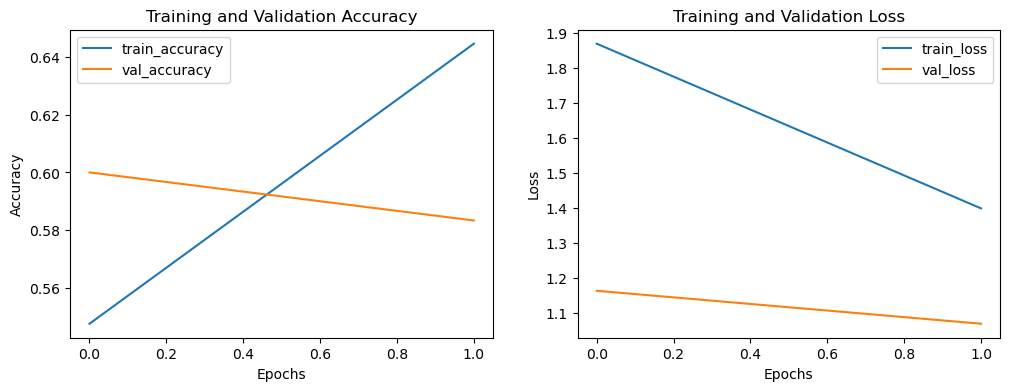

In [27]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'], label='train_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Model Predictions and Metrics

In [28]:
from keras.models import load_model

# model = load_model('Model1.h5')

predictions = model.predict(testGen)
predicted_classes = np.argmax(predictions, axis=1)

60/60 [==============================] - 5s 64ms/step


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

true_classes = testGen.classes
class_labels = list(testGen.class_indices.keys())
custom_class_labels = ['Healthy', 'Glaucoma']

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=custom_class_labels))

Accuracy: 0.5833333333333334
Precision: 0.8571428571428571
Recall: 0.2
F1 Score: 0.32432432432432434

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.55      0.97      0.70        30
    Glaucoma       0.86      0.20      0.32        30

    accuracy                           0.58        60
   macro avg       0.70      0.58      0.51        60
weighted avg       0.70      0.58      0.51        60



# Confusion Matrix

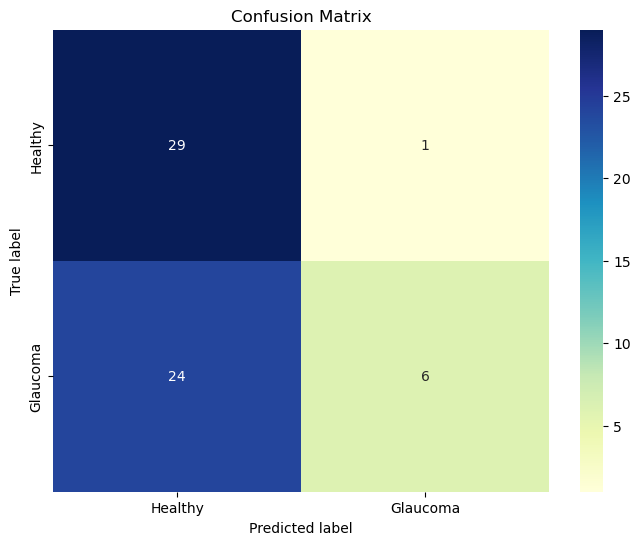

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=custom_class_labels, yticklabels=custom_class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")
plt.show()

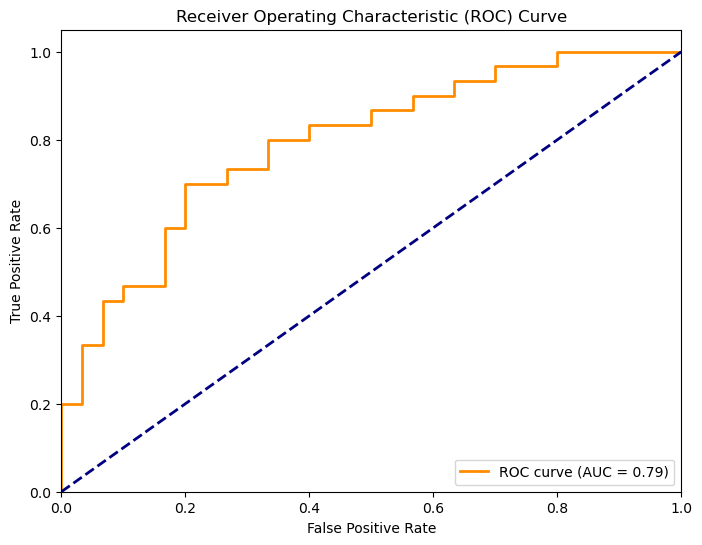

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])

# Calculate the AUC score
roc_auc = roc_auc_score(true_classes, predictions[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()